In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt
from math import sqrt


# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp

In [3]:
from scipy import ndimage
from scipy.io import loadmat
from scipy import stats
from scipy.spatial import cKDTree

In [4]:
#Tweakable variables:\

diameter = 5
minimal_mass = 25
max_displacement = 15
mpp = 2/7.
fps = 15
min_path = 50
size = 5
eccentricity = 0.7
min_pixel_deviation = 5
neighboor_number = 3
minframes = 30

In [7]:
# The as_gray function didn't work on my com
@pims.pipeline
def gray(image):
    return image[:, :, 1]  # Take just the green channel

# Function to test if the particles are located correctly
def Test_Frame(dataframes, frame_number=0, min_mass=minimal_mass):
    f = tp.locate(dataframes[frame_number], diameter, invert=True, minmass=min_mass)
    selection = tp.annotate(f, dataframes[frame_number])
    return selection

# Function to check the Mass distribution of the particles to see if you should adjust the minimal_mass
def Check_Mass(dataframes, frame_number = 0, numb_bins = 40):
    f = tp.locate(dataframes[frame_number], diameter, invert=True)
    fig, ax = plt.subplots()
    ax.hist(f['mass'], bins = numb_bins)
    ax.set(xlabel='mass', ylabel='count');

# Function linking the trajectories of the particles and changing the perso 

###ADDED a memory open parameter with default 10, should be less in our case because particles dont travel out of FOV
def Track_Linking(dataframes, min_mass=minimal_mass, dia = diameter,memory =10):
    f = tp.batch(dataframes, dia, invert=True, minmass=min_mass, maxsize = size)
    t = tp.link(f, max_displacement, memory)
    t1 = tp.filter_stubs(t, min_path)            # filter out particles that dissapear
    t2 = t1[((t1['mass'] > min_mass) & (t1['size'] < size) & (t1['ecc'] < eccentricity))]   #filter out particles that are irregular
    return t2

# An easy function to find the distance with an input of the coordinates of two particles
def Distance(x1, y1, x2, y2):
    dist = sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist

def Currentless_Drift(testframes, min_mass = minimal_mass):
    t2 = Track_Linking(testframes, min_mass = minimal_mass)
    d = tp.compute_drift(t2)
    d.plot()
    plt.show()
    return d

# Function that 'creates a rectangle box' of the maximal displacement of the particle and returns a list of the length of the diagonals of the particles
def Maximal_Distance(traject):
    maxdlist=[]
    for item in traject.particle.unique():
        indiv = traject[traject['particle'] == item]       #only returns one particle with which you can make an array of x and y values
        indiv_x, indiv_y = np.asarray(indiv.x), np.asarray(indiv.y)
        dev = Distance(indiv_x.min(), indiv_y.min(), indiv_x.max(), indiv_y.max())     #uses distance function to calculate the diagonal
        maxdlist.append(dev)
    return maxdlist    # is in order of the particles, which will always be ordered from first to last, due to origin of the particle id

def Single_Frame(Data_frame=None, frame=None, Plot_traj=False, Plot_MSD = False, Help = False):
    if Help == True:
        print ("This function Singles out individual frames from the data frame provided based on particle id")
    else:
        selection=Data_frame.loc[Data_frame['frame']==frame]
        return selection

def Nearest_Neighboors(frame_df,number_of_neighboors):
    frame_result_list = []
    particles = np.asarray([frame_df['y'],frame_df['x']]).T
    Nearest_Neighboors_Tree = cKDTree(particles, leafsize=100)
    for item in particles:
        TheResult = Nearest_Neighboors_Tree.query(item, k=number_of_neighboors,p=2, distance_upper_bound=10)
        frame_result_list.append(TheResult)
    return frame_result_list

def Neighboors_frames(trajectories,number_of_neighboors):
    Neighboors_list = []
    for i in range (0,len(trajectories.frame.unique())):
        single_frame = Single_Frame(trajectories,trajectories.frame.unique()[i])
        single_frame = single_frame.set_index('particle')
        correction_list = single_frame.index.values
        dummy_var = Nearest_Neighboors(single_frame,number_of_neighboors)
        for j in range (0, len(dummy_var)):
            dummy = dummy_var[j]
            dummy = np.asarray(dummy).T
            for element in dummy:
                element[1] = element[1]+1
            dummy[0][0] = 'Nan'
            for element in dummy:
                if element[0] == float('inf'):
                    element [0] = 0
                    element [1] = 0
            dummy=dummy[dummy!=0]
            dummy = dummy.reshape((int((len(dummy)/2)),2))
            dummy_var[j] = dummy
        for l in range (0,len(dummy_var)):
            for element in dummy_var[l]:
                element[1] = correction_list[int((element[1])-1)]
        Neighboors_list.append(dummy_var)
       
    return Neighboors_list

# Function that creates a dataframe that returns the particles with their neighbours (dependent on number_of_neighboors)
def Neighboors_Trajectories(trajectories, number_of_neighboors):
    neighboors_list = Neighboors_frames(trajectories, number_of_neighboors)    # creates the list of list of arrays
    known_neighbours = pd.DataFrame(columns=['frame','particle'])          # only these two columns because only these are independent of number_of_neighboors
    for h in range(number_of_neighboors):                            # creates the empty columns of the dataframe dependent on number_of_neighboors
        neighbour = 'neighbour ' + str(h+1)
        distance = 'distance ' + str(h+1)
        known_neighbours[neighbour] = np.nan
        known_neighbours[distance] = np.nan
    for i in range(trajectories.frame.nunique()):              # loops through all the frames
        neighbour_frame = neighboors_list[i]
        for j in range(len(neighbour_frame)):                  # loops throug all the particles in one frame
            one_part = neighbour_frame[j]                      # takes only the one particle
            if len(one_part) == 0:                            # this avoids crashing in case of an error in the Neighboors_frames function,
                continue
            else:
                known_neighbours.at[len(known_neighbours),'frame'] = i       # creates a new row of data at the bottom row
                known_neighbours.at[len(known_neighbours)-1,'particle'] = int(one_part[0][1])        # the row already exists so is at index (length of dataframe-1)
            for l in range(number_of_neighboors):              # only adds new columns if number_of_neighboors determines it
                if len(one_part) >= l+2:                       # if list longer than two, the particle has nearest neighboors, at max (number_of_neighboors +2)
                    neig = 'neighbour ' + str(l+1)
                    dist = 'distance ' + str(l+1)
                    known_neighbours.at[len(known_neighbours)-1, neig] = one_part[l+1][1]
                    known_neighbours.at[len(known_neighbours)-1, dist] = one_part[l+1][0]
    return known_neighbours                 # returns the dataframe

# Function that finds the monomers within a neighboor dataframe, based on a minimum of frames with neighboors to no longer be a monomer
def Find_Monomers(neighboor_df, minimal_frames):
    monomer_list = []
    for i in range(max(neighboor_df.particle.unique())):    
        if i in neighboor_df.particle.unique().tolist():
            if len(neighboor_df[(neighboor_df['particle']==float(i)) & (neighboor_df['neighbour 1']>float(0))]) < minimal_frames:  # if a particle has more than a number of frames with a nearest neighbour, it won't be a monomer
                monomer_list.append(i)
    return monomer_list     # returns a list of monomers

# Function that finds dimers in a dataframe and returns a list of particle id's 
def Find_Dimers(neighboor_df, number_of_neighboors, minimal_frames):
    dimer_list = []
    for i in range(max(neighboor_df.particle.unique())):           # loops through all the particles
        if i in neighboor_df.particle.unique().tolist():           # shortens the time, doesn't go on if the particle is not in the list
            for j in range(max(neighboor_df.particle.unique())):     # loops through all other particles to see if it has any connections with one of them   
                length = 0
                for k in range(number_of_neighboors):    # if it appears in one of the dataframes as a first, second, etc nearest neighbour it adds it to the number of frames where it has a friend
                    neigh = 'neighbour ' + str(k+1)
                    length += len(neighboor_df[(neighboor_df['particle']==float(i)) & (neighboor_df[neigh]==float(j))])
                if  length >= minimal_frames:              # if the length of frames in which the particles exceeds a value, it is counted as a dimer
                    dimer_list.append(i)
            # here I could add a function to see if a particle appears multiple times leaving the possibility of being a trimer, etc. now only classified as a dimer
    return dimer_list
                    

# Start of a function to make a new column and assign the particle a status of 'stuck', 'monomer', 'dimer', etc. This function runs in ~4 min in my computer, which is not as fast as hoped, but still quite fast :
def Assign_Particles(trajectory, mpd = min_pixel_deviation, number_of_neighboors = neighboor_number, minimal_frames=minframes, **kwargs):

#Assigning the particles with non-significant (smaller than a small value 'mpd') iterations the label stuck 
    maxlist = Maximal_Distance(trajectory) 
    stuck_particles = []
    for i in range(trajectory.particle.nunique()):
        if maxlist[i] < mpd:                           # if the particle displacement is smaller than this value, the particle id will be added to the stuck_particles list
            stuck_particles.append(trajectory.particle.unique()[i])   # due to the nature of the particlenomenclature, this will not give errors
    traj_copy = trajectory.copy()                      # to preserve the original trajectory
    traj_copy['stuck'] = np.nan
    traj_copy['stuck'] = traj_copy['particle'].apply(lambda x: True if x in stuck_particles else False)    # this function only makes the stuck-value True if the particle id is in the stu stuck particles list
    
# Assigning the other particles within the code
    no_stucks = traj_copy[traj_copy['stuck']==False]              # filters out the stuck particles, as we all ready know they are stuck
    no_stucks_list = traj_copy.particle.unique().tolist()           # makes a list to later make a dimer list
    neighboor_df = Neighboors_Trajectories(no_stucks, number_of_neighboors)   
    monomer_list = Find_Monomers(neighboor_df, minimal_frames)       # finds the monomers in the dataframe
    no_monomer_list = [elem for elem in no_stucks_list if elem not in monomer_list]   # filters the monomers out of the total list of particles   
    no_monomer = neighboor_df[neighboor_df.particle.isin(no_monomer_list)]              # only selects the particles that are in the list without monomers
    dimer_list = Find_Dimers(no_monomer, number_of_neighboors, minimal_frames)   
    traj_copy['form'] = np.nan
    traj_copy['form'] = traj_copy['particle'].apply(lambda x: 'monomer' if x in monomer_list else ('dimer' if x in dimer_list else ('stuck' if x in stuck_particles else 'unknown')))  # appoints the particle being stuck, a monomer, a dimer or unknown in the list
    return traj_copy

In [8]:
# The as_gray function didn't work on my computer, so I returned to using this, as was done in the tutorial of TrackPy
frames = gray(pims.ImageSequence(r'C:\Users\jonsc\Videos\Scriptie\210415_Hydphyl_pH8_1MMgSO4\UCoa1Loc20Vpp52kHz/*.png'))

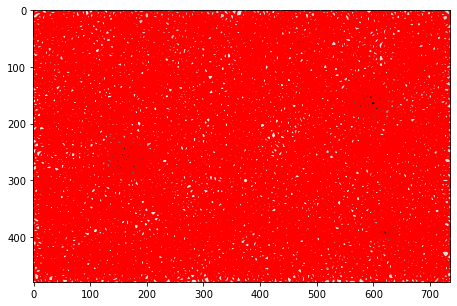

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,2.000000,69.536481,14.236301,1.142244,1.456250e+00,4.4603,2051.0,0.098066,0
1,3.800000,53.061538,7.943000,1.189699,2.179958e-01,1.7719,1745.0,-1.021766,0
2,3.353982,102.575221,6.904300,1.240896,6.670174e-01,1.8330,1767.0,-5.707766,0
3,3.000000,118.000000,1.955200,0.000000,3.200000e+07,1.9552,1738.0,-0.810139,0
4,3.127119,181.838983,7.209800,1.149797,6.640310e-01,1.4664,1889.0,0.233614,0


In [9]:
f = tp.locate(frames[0], diameter=diameter,invert = True)
plt.figure()
tp.annotate(f,frames[0])
f.head()

[Text(0.5, 0, 'mass'), Text(0, 0.5, 'count')]

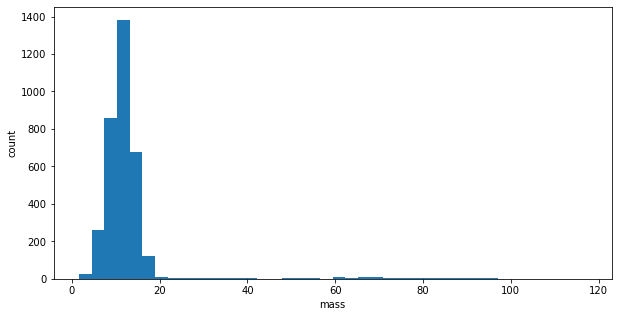

In [10]:
#Mass signifies the brightness, we can find a threshold by looking at the histogram
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=40)
ax.set(xlabel='mass', ylabel='count')

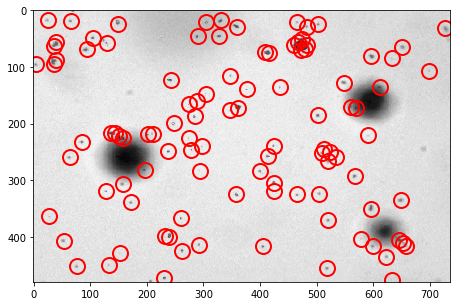

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
111,17.178771,25.019553,43.747602,1.355724,0.048767,4.8880,2015.0,0.112582,0
119,17.966057,331.747607,70.203903,1.347725,0.135670,7.7597,2367.0,0.046002,0
127,19.075045,65.813743,67.576602,1.334952,0.119228,8.4318,2120.0,0.078633,0
136,20.241681,305.266200,34.888101,1.242843,0.417542,5.6212,2111.0,0.080719,0
141,21.055886,465.806183,51.385102,1.311252,0.223332,6.4766,1981.0,0.130879,0


In [11]:
f = tp.locate(frames[0], diameter=diameter, invert=True, minmass=25)
plt.figure()
tp.annotate(f,frames[0])
f.head()

In [12]:
# for now only tried with first 500 frames to see if it would work, over the weekend, I will also try the full fragment to see if my memory can hold it
f = tp.batch(frames[:500], diameter=diameter, minmass=minimal_mass, invert=True)

Frame 499: 106 features


In [13]:
t = tp.link_df(f, max_displacement, memory=30)

Frame 499: 106 trajectories present.


In [14]:
t1 = tp.filter_stubs(t, 45)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 223
After: 146


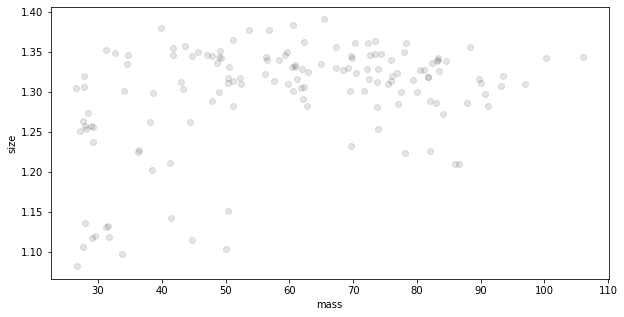

<AxesSubplot:xlabel='mass', ylabel='size'>

In [15]:
plt.figure()
tp.mass_size(t1.groupby('particle').mean())

In [16]:
condition = lambda x: ((x['mass'].mean() > 10) & (x['size'].mean() < 3))
t2 = tp.filter(t1, condition)  # a wrapper for pandas' filter that works around a bug in v 0.12
print('Before:', t1['particle'].nunique())
print('After:', t2['particle'].nunique()) 
t2.head()

Before: 146
After: 146


,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
frame,,,,,,,,,,
0,17.178771,25.019553,43.747602,1.355724,0.048767,4.8880,2015.0,0.112582,0,0
0,319.756944,423.805556,35.193601,1.174084,0.271468,6.3544,1810.0,0.716706,0,1
0,319.222222,128.156816,77.535903,1.239296,0.271532,11.0591,2028.0,0.106870,0,2
0,307.602163,157.608173,50.835202,1.344057,0.203424,7.3320,2060.0,0.095003,0,3
0,304.936455,424.779264,91.344503,1.359471,0.036476,10.0204,2332.0,0.048876,0,4


In [17]:
# Here I change the dataframe to add the form in which the particle exists, still needs some tweaking but the code doesn't quit anymore
t3 = Assign_Particles(t2)

In [18]:
stuck_particles= t3[t3['stuck']==True]
monomers = t3[t3['form']=='monomer']
dimers = t3[t3['form']=='dimer']

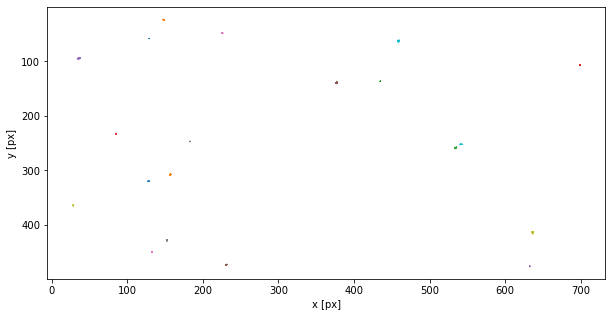

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [19]:
plt.figure()
tp.plot_traj(stuck_particles)


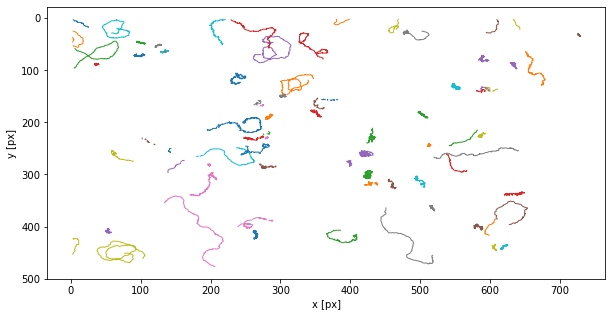

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [20]:
# Some suspicious circular movement, so maybe there are still some dimers in here
plt.figure()
tp.plot_traj(monomers)

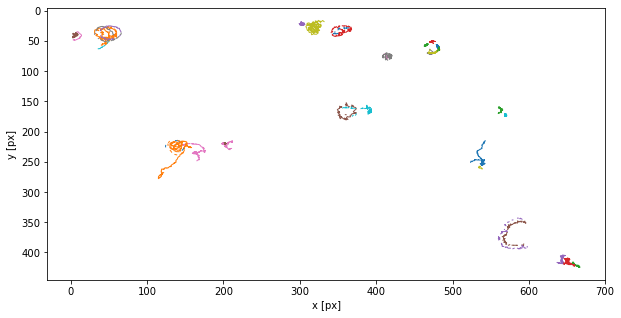

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [21]:
# The dimers do seem to make more circular movements than the monomers!!!!
plt.figure()
tp.plot_traj(dimers)

In [22]:
t3.to_csv(r'C:\Users\jonsc\OneDrive\Documenten\Studie\Scriptie\Dataframes\210415_UCoa1Loc20Vpp52kHz.csv')